In [1]:
# Importando as bibliotecas necessárias

"""
Titanic
github @rafaelmm82
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics


Using TensorFlow backend.


# TITANIC (@rafael magalhães)

Este notebook trata da resolução da Lista 2 (parte 2) da disciplina de DeepLearning (UFPB). O notebook é organizado de acordo com seis pontos principais solicitados na descrição do problema:
1. Definição do problema
2. Entendendo o dataset
3. Identificando problemas
4. Solucionando problemas
5. Correlação
6. Implementando a rede neural

# 1. Definição do Problema

> Nessa atividade, será utilizado como base de dados informações dos passageiros do Titanic para identificar quais passageiros sobreviveram. No Titanic, uma das razões que causou o naufrágio foi que não havia botes salva-vidas suficientes para os passageiros e a tripulação. Dentre os passageiros, alguns grupos de pessoas tinham maior probabilidade de sobreviver do que outros, como mulheres, crianças e a classe alta. Dessa forma, o problema consiste em utilizar rede neural para identificar quais pessoas poderiam sobreviver. A base de dados é dividida em treino e teste, considere a base de teste titanic3.xls. Para leitura do arquivo em Python, utilize a função do Pandas para leitura de arquivos. O treino deverá ser realizado por validaçaão cruzada e por holdout e os resultados devem ser comparados.

Para a resolução deste problema foi utilizado a base de dados "train.csv" e "test.csv". Sendo o primeiro composto por features e targets, e o último apenas com as features. Apesar e investigado, não foi feito a utilização do arquivo "titanic3.xls"


# 2. Entendendo o dataset

> Para iniciar, deve-se analisar os atributos de entrada do dataset, seus tipos e o atributo alvo (label/rótulo). Isso pode ser feito através do Pandas, biblioteca de Python específica para análise e preprocessamento de dados. Isso pode ser feito através da biblioteca Pandas, que permite analisar e preprocessar dados.

A primeira etapa de coding trata da obtenção dos dados.

In [7]:
# Importando os dados
# ###################

d_train = pd.read_csv('train.csv')
d_test = pd.read_csv('test.csv')

print("Preview do dataset de treinamento")
d_train.head()

#print("Preview do dataset de teste (pós-validacão)")
#d_test.head()

Preview do dataset de treinamento


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 3. Identificando problemas

> Mesmo com uma base de dados previamente definida, muitas vezes existem problemas que não foram tratados nela, sendo necessário analisar manualmente. Dentre os problemas, para bases de texto, três são bastante comuns:
Instâncias com informações faltando (NaN) para determinados atributos
> * Dados discrepantes e outliers
> * Dados desbalanceados

A partir dos atributos e métodos de descrição dos datasets (em Pandas) foi possível observar o seguinte:


In [11]:
# Descrevendo os dados
print('\nCabeçalhos')
print(d_train.columns)

print('\nInformações gerais')
d_train.info()


Cabeçalhos
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Informações gerais
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### Analisando o data info
```python
d_train.info() # retornou a seguinte análise:
```
São 891 dados no total, dos quais:
* PassengerID ok (int64) [0-891] (não precisa usar)
* Survived ok (int64) binário variando entre [0;1]
* Pclass ok (int64) unitário variando [1-3]  
    * transformar em one-hot
* Name ok (object)
    * talvez obter os títulos (Mr. Miss, etc...)
* Sex ok (objetc)
    * transformar em (int64) [0;1]
* Age NOT OK (float64)
    * Faltando vários, pensar em como preencher, zerar ou analisar a correlação em idade e sobrevivência por faixa etária
* SibSp ok (int64)
    * transformar em one-hot
* ParCh ok (int64)
    * transformar em one-hot
* Ticket ok (object)
    * talvez relacionar à categoria classe, ou local [código]
    * observar relação com CREW (staff)
* Fare ok (float64)
    * relacionar com local de embarque (valor da moeda local)
    * relacionar com classe
    * relacionar com cabin
* Cabin NOT OK (object)
    * Faltando vários
    * relacionar com classe
    * relacionar com preço do ticket
* Embarked NOT OK (object)
    * comparar com os preços de bilhetes


# 4. Solucionando problemas

> Os problemas podem ser solucionados utilizando algumas medidas estatísticas como média, mediana e moda para substituir as informações que estão faltando e dados discrepantes, ou excluir as instâncias. Além disso, quanto mais balanceado o dataset, menos propensa estará a rede a cometer erros de generalização. A resolução pode ser feita das duas formas utilizando o Pandas.

Foram implementados procedimentos para cada coluna de Feature baseado em suas características. Essencialmente foram preenchidas com valores condizentes os campos sem dados (NaN), categorizados numericamente as Features com strings, transformadas em (one hot encoding) todas as classes de categorias e, por fim, determinado um novo DataFrame (Pandas) para o conjunto traning and validation (test dentro do training)

In [12]:
# Organizando as informações que faltam e ajeitando os dados
d_train.Cabin.describe()

# Organizando a Feature PClass em one hot encoding
NewPClass = d_train['Pclass'].copy()
NewPClass_onehot = to_categorical(NewPClass)
NewPClass_labels = ['PC-1', 'PC-2', 'PC-3']
NewPClass_DF = pd.DataFrame(data=NewPClass_onehot[:,1:], columns=NewPClass_labels )

# Identificando Titulos
# Postergado para outro momento

# Organizando a Feature Age em one hot encoding
NewAge = d_train['Age'].copy()
NewAge = NewAge.fillna(-0.5)
Abins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
Age_labels = [0, 1, 2, 3, 4, 5, 6, 7]
AgeCat = pd.cut(NewAge, Abins, labels=Age_labels)
NewAge_onehot = to_categorical(AgeCat)
NewAge_labels = ['A-Unkn', 'A-Baby', 'A-Chil', 'A-Teen', 'A-Stud', 'A-Youn', 'A-Adul', 'A-Seni']
NewAge_DF = pd.DataFrame(data=NewAge_onehot, columns=NewAge_labels[:])

# Organizando Feature Sex em one hot
NewSex = d_train['Sex'].copy()
label_encoder = LabelEncoder()
NewSex_int = label_encoder.fit_transform(NewSex)
NewSex_onehot = to_categorical(NewSex_int)
NewSex_labels = ['S-f', 'S-m']
NewSex_DF = pd.DataFrame(data=NewSex_onehot, columns=NewSex_labels)

# Convertendo SipSp em one hot
NewSibSp = d_train['SibSp'].copy()
NewSibSp_onehot = to_categorical(NewSibSp)
NewSibSp_labels = ['SP-0', 'SP-1', 'SP-2', 'SP-3', 'SP-4', 'SP-5', 'SP-6', 'SP-7', 'SP-8']
NewSibSp_DF = pd.DataFrame(data=NewSibSp_onehot, columns=NewSibSp_labels)

# Convertendo ParCh em one hot
NewParch = d_train['Parch'].copy()
NewParch_onehot = to_categorical(NewParch)
NewParch_labels = ['Pa-0', 'Pa-1', 'Pa-2', 'Pa-3', 'Pa-4', 'Pa-5', 'Pa-6']
NewParch_DF = pd.DataFrame(data=NewParch_onehot, columns=NewParch_labels)

# Convertendo Fare em 4 categorias one hot
NewFare = d_train['Fare'].copy()
NewFare = NewFare.fillna(-0.5)
Fbins = (-1, 0, 8, 15, 31, 1000)
NewFare_templabels = [0, 1, 2, 3, 4]
NewFare_bin = pd.cut(NewFare, Fbins, labels=NewFare_templabels)
NewFare_onehot = to_categorical(NewFare_bin)
NewFare_labels = ['F-U', 'F-1', 'F-2', 'F-3', 'F-4']
NewFare_DF = pd.DataFrame(data=NewFare_onehot, columns=NewFare_labels)

# Organizando a Feature Cabin em one hot encoding
NewCabin = d_train['Cabin'].copy()
NewCabin = NewCabin.fillna('N')
NewCabin = NewCabin.apply(lambda x: x[0])
label_encoder = LabelEncoder()
NewCabin_int  = label_encoder.fit_transform(NewCabin)
NewCabin_onehot = to_categorical(NewCabin_int)
NewCabin_labels = ['C-A', 'C-B', 'C-C', 'C-D', 'C-E', 'C-F', 'C-G', 'C-N', 'C-T']
NewCabin_DF = pd.DataFrame(data=NewCabin_onehot, columns=NewCabin_labels)

# Organizando Embarked one hot
NewEmb = d_train['Embarked'].copy()
NewEmb = NewEmb.fillna('N')
label_encoder = LabelEncoder()
NewEmb_int = label_encoder.fit_transform(NewEmb)
NewEmb_onehot = to_categorical(NewEmb_int)
NewEmb_labels = ['E-C', 'E-N', 'E-Q', 'E-S']
NewEmb_DF = pd.DataFrame(data=NewEmb_onehot, columns=NewEmb_labels)

# 5. Correlação

> Uma vez que o dataset foi analisado e possíveis erros foram corrigidos, é importante também verificar a correlação dos atributos. A correlação é uma métrica estatística que mede a associação entre os atributos. Caso existam atributos altamente correlacionados, pode-se excluir alguns deles, permanecendo apenas um dos atributos correlacionados.

Em substituição desta etapa, visto que objetiva-se apenas uma primeira análise e teste de aprendizagem, optou-se por simplemente montar o dataset removendo as informações de PassengerID, Ticket e Name, por entender que são informações não correlacionadas ou que não geram valor imediato informativo para a classificação.

In [15]:
# PREPARANDO O DATASET Training Testing

Din_total = pd.concat([NewAge_DF, NewSex_DF, NewSibSp_DF, NewParch_DF, NewFare_DF, NewCabin_DF, NewEmb_DF], axis=1)

Dout_total = d_train['Survived'].copy().astype('float64')

(x_train, x_test, y_train, y_test) = train_test_split(Din_total, Dout_total, test_size=0.2)

#print('\nSobre o dataset')
#x_train.describe()

print('\nExemplo do dataset')
x_train.head()


Exemplo do dataset


,A-Unkn,A-Baby,A-Chil,A-Teen,A-Stud,A-Youn,A-Adul,A-Seni,S-f,S-m,...,C-D,C-E,C-F,C-G,C-N,C-T,E-C,E-N,E-Q,E-S
206,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
393,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
344,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
223,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
294,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


# 6. Implementando a rede neural

> Uma vez que a base de dados foi analisada e possíveis problemas foram corrigidos, pode-se implementar a rede neural. Para esse problema, é necessário uma arquitetura multicamada MLP de no máximo 6 camadas escondidas, recomendando-se a implementação das camadas de forma gradual. Da mesma forma, cada camada deverá conter no máximo 30 neurônios. Além disso, recomenda-se a utilização de técnicas de regularização como Dropout, normalização do batch e normalização L2.
Utilize o otimizador de sua escolha para o treinamento por batch, aumente a quantidade de epochs e batch também gradativamente, não é necessário uma quantidade muito alta para resolução do problema. Ao final, mostre a curva de treinamento e a matriz de confusão obtida para o problema.



In [19]:
# DEFININDO A ARQUITETURA

dimIn = x_train.shape[1]
dimOut = 1
model = Sequential()
model.add(Dense(30, activation='relu', input_shape=(dimIn,)))
model.add(Dense(30, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(dimOut, activation='sigmoid'))

#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['accuracy'])

# Training the model
history = model.fit(x_train, y_train, epochs=10, verbose=1, validation_data=(x_test, y_test))


Train on 712 samples, validate on 179 samples
Epoch 1/10
712/712 [==============================] - 0s 534us/step - loss: 0.2215 - acc: 0.6629 - val_loss: 0.2007 - val_acc: 0.7095
Epoch 2/10
712/712 [==============================] - 0s 106us/step - loss: 0.1866 - acc: 0.7514 - val_loss: 0.1753 - val_acc: 0.7654
Epoch 3/10
712/712 [==============================] - 0s 109us/step - loss: 0.1655 - acc: 0.7725 - val_loss: 0.1567 - val_acc: 0.8156
Epoch 4/10
712/712 [==============================] - 0s 114us/step - loss: 0.1518 - acc: 0.8034 - val_loss: 0.1490 - val_acc: 0.8212
Epoch 5/10
712/712 [==============================] - 0s 116us/step - loss: 0.1453 - acc: 0.8034 - val_loss: 0.1490 - val_acc: 0.7654
Epoch 6/10
712/712 [==============================] - 0s 121us/step - loss: 0.1414 - acc: 0.8090 - val_loss: 0.1443 - val_acc: 0.8101
Epoch 7/10
712/712 [==============================] - 0s 119us/step - loss: 0.1374 - acc: 0.8216 - val_loss: 0.1423 - val_acc: 0.8156
Epoch 8/10
712/7

### Apresentando a curva de erro do treinamento e validação

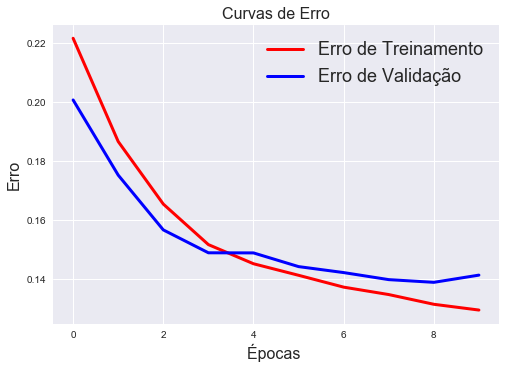

In [20]:
plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Erro de Treinamento', 'Erro de Validação'],fontsize=18)
plt.xlabel('Épocas ',fontsize=16)
plt.ylabel('Erro',fontsize=16)
plt.title('Curvas de Erro',fontsize=16)
plt.show()

### Gerando a matriz de confusão


Valores contidos da matriz de confusão
[[96 12]
 [24 47]]

Acurárica :  0.798882681564




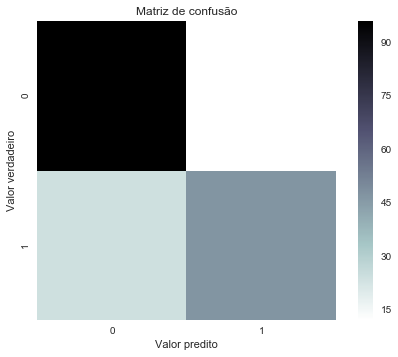

In [24]:
# prediendo para análise
test_predictions = model.predict_classes(x_test)

cm = metrics.confusion_matrix(y_test, test_predictions)

print('\nValores contidos da matriz de confusão')
print(cm)
print('\nAcurárica : ', ((cm[0,0]+cm[1,1])/np.sum(cm)))
print('\n')

cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(cm, cmap="bone_r")
ax.set_aspect(1)
plt.title("Matriz de confusão")
plt.ylabel("Valor verdadeiro")
plt.xlabel("Valor predito")
plt.show()
